In [9]:
# https://www.tensorflow.org/get_started/get_started

import tensorflow as tf
from showgraph import show_graph

In [5]:
sess = tf.Session()
left = tf.add(
    tf.constant(3.0),
    tf.constant(4.0)
)
right = tf.add(
    tf.constant(2.0),
    tf.constant(9.0)
)
sess.run([left, right])
# show_graph(tf.get_default_graph().as_graph_def())

[7.0, 11.0]

In [27]:
a = tf.placeholder(tf.float32)
b = tf.placeholder(tf.float32)
c = tf.placeholder(tf.float32)
adder_node = a + b
print(sess.run(adder_node, {a: 3, b:4.5}))

print(sess.run(adder_node, {a: [1,3], b: [2, 4]}))


out = (a + b) * c
print(sess.run(out, {a: [1,2,3], b: [2,4,6], c: 3}))




7.5
[ 3.  7.]
[  9.  18.  27.]


In [41]:
# model with trainable variables.

a = tf.Variable([.3], tf.float32)
b = tf.Variable([-.3], tf.float32)
x = tf.placeholder(tf.float32)
linear_model = a * x + b

init = tf.global_variables_initializer()
sess.run(init)
print(sess.run(linear_model, {x:[1,2,3,4]}))


# placeholder for collecting output of model
y = tf.placeholder(tf.float32)
squared_deltas = tf.square(linear_model - y)
loss = tf.reduce_sum(squared_deltas) # sum of squares of deltas.

print(sess.run(loss, {x:[1,2,3,4], y:[-0,-1,-2,-3]})) # compare output of x to training data outputs (y)
# 23.66

fixa = tf.assign(a, [-1.]) # this is what the linear comb should be.
fixb = tf.assign(b, [1.])
sess.run([fixa, fixb])
print(sess.run(loss, {x:[1,2,3,4], y:[-0,-1,-2,-3]})) # compare output of x to training data outputs (y)
# 0


[ 0.          0.30000001  0.60000002  0.90000004]
23.66
0.0


In [44]:
# now let's add an optimizer that will find the values of a and b itself.

optimizer = tf.train.GradientDescentOptimizer(0.01)
train = optimizer.minimize(loss)

sess.run(init) # reset values to incorrect defaults.

for i in range(1000):
  sess.run(train, {x:[1,2,3,4], y:[0,-1,-2,-3]})

print(sess.run([a, b]))


[array([-0.9999969], dtype=float32), array([ 0.99999082], dtype=float32)]


a: [ 0.99661887] b: [ 122.4333725] loss: 3.31926e+06


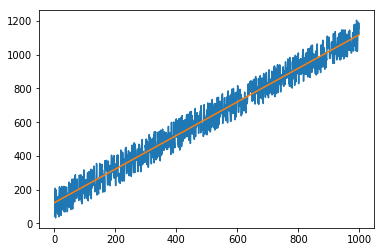

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random

a = tf.Variable([-.3], tf.float32)
b = tf.Variable([.3], tf.float32)
x = tf.placeholder(tf.float32)
y = tf.placeholder(tf.float32)

model = a * x + b

loss = tf.reduce_sum(tf.squared_difference(model, y)) # Sum((y - y_i)^2)

learning_rate = 1
iteration = 1000

train = tf.train.AdamOptimizer(learning_rate).minimize(loss)

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

# training data
x_train = [x for x in range(1,1000)]
y_train = [i + 20 + (200 * random.random()) for i in range(1,1000)]


sess = tf.Session()
sess.run(init) # reset values to wrong
for i in range(iteration):
  sess.run(train, {x:x_train, y:y_train})

curr_a, curr_b, curr_loss = sess.run([a, b, loss], {x:x_train, y:y_train})

print("a: %s b: %s loss: %s" % (curr_a, curr_b, curr_loss))

y_predict = sess.run(model, {x:x_train})
plt.plot(x_train, y_train)
plt.plot(x_train, y_predict)
plt.show()



In [57]:
# Example using tf.contrib.learn

import tensorflow as tf
import numpy as np

features = [tf.contrib.layers.real_valued_column("x", dimension=1)]

estimator = tf.contrib.learn.LinearRegressor(feature_columns=features)

x = np.array([1., 2., 3., 4.])
y = np.array([0., -1., -2., -3.])

input_fn = tf.contrib.learn.io.numpy_input_fn({"x":x}, y, batch_size=4,
                                              num_epochs=1000)

estimator.fit(input_fn=input_fn, steps=1000)

print(estimator.evaluate(input_fn=input_fn))



INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x119a71198>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': None}
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving

In [55]:
# Now let's do that with a custom model (instead of linear regression).

import numpy as np
import tensorflow as tf

def model(features, labels, mode):
    # model sub graph
    a = tf.get_variable("a", [1], dtype=tf.float64)
    b = tf.get_variable("b", [1], dtype=tf.float64)
    y = a * features['x'] + b
    # Loss sub graph
    loss = tf.reduce_sum(tf.square(y - labels))
    # Training sub-graph
    global_step = tf.train.get_global_step()
    optimizer = tf.train.GradientDescentOptimizer(0.01)
    train = tf.group(optimizer.minimize(loss),
                   tf.assign_add(global_step, 1))
    # ModelFnOps connects subgraphs we built to the
    # appropriate functionality.
    return tf.contrib.learn.ModelFnOps(
      mode=mode, predictions=y,
      loss=loss,
      train_op=train)

estimator = tf.contrib.learn.Estimator(model_fn=model)
x = np.array([1., 2., 3., 4.])
y = np.array([0., -1., -2., -3.])
input_fn = tf.contrib.learn.io.numpy_input_fn({"x": x}, y, 4, num_epochs=1000)

# train
estimator.fit(input_fn=input_fn, steps=1000)
# evaluate our model
print(estimator.evaluate(input_fn=input_fn, steps=10))
    

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x119a718d0>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': None}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/h_/hlb_3mzs0h9d757_gq0rsyx000dkx2/T/tmpmofm93ss/model.ckpt.
INFO:tensorflow:loss = 5.08914138088, step = 1
INFO:tensorflow:global_step/sec: 1044.78
INFO:tensorflow:loss = 0.0674682248499, step = 101 (0.097 sec)
INFO:tensorflow:global_step/sec: 1109.29
INFO:tensorflow:loss = 0.0039179864069, 